# How to add multi-turn conversation in a multi-agent application

!!! info "Prerequisites"
    This guide assumes familiarity with the following:

    - [Node](../../concepts/low_level/#nodes)
    - [Command](../../concepts/low_level/#command)
    - [Multi-agent systems](../../concepts/multi_agent)
    - [Human-in-the-loop](../../concepts/human_in_the_loop)


In this how-to guide, we’ll build an application that allows an end-user to engage in a *multi-turn conversation* with one or more agents. We'll create a node that uses an [`interrupt`](../../reference/types/#langgraph.types.interrupt) to collect user input and routes back to the **active** agent.

The agents will be implemented as nodes in a graph that executes agent steps and determines the next action:  

1. **Wait for user input** to continue the conversation, or  
2. **Route to another agent** (or back to itself, such as in a loop) via a [**handoff**](../../concepts/multi_agent/#handoffs).

```python
def human(state: MessagesState) -> Command[Literal["agent", "another_agent"]]:
    """A node for collecting user input."""
    user_input = interrupt(value="Ready for user input.")

    # Determine the active agent.
    active_agent = ...

    ...
    return Command(
        update={
            "messages": [{
                "role": "human",
                "content": user_input,
            }]
        },
        goto=active_agent,

def agent(state) -> Command[Literal["agent", "another_agent", "human"]]:
    # The condition for routing/halting can be anything, e.g. LLM tool call / structured output, etc.
    goto = get_next_agent(...)  # 'agent' / 'another_agent'
    if goto:
        return Command(goto=goto, update={"my_state_key": "my_state_value"})
    else:
        return Command(goto="human") # Go to human node
    )
```

## Setup

First, let's install the required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai

In [106]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Travel Recommendations Example

In this example, we will build a team of travel assistant agents that can communicate with each other via handoffs.

We will create 3 agents:

* `travel_advisor`: can help with general travel destination recommendations. Can ask `sightseeing_advisor` and `hotel_advisor` for help.
* `sightseeing_advisor`: can help with sightseeing recommendations. Can ask `travel_advisor` and `hotel_advisor` for help.
* `hotel_advisor`: can help with hotel recommendations. Can ask `sightseeing_advisor` and `hotel_advisor` for help.

This is a fully-connected network - every agent can talk to any other agent. 

To implement the handoffs between the agents we'll be using LLMs with structured output. Each agent's LLM will return an output with both its text response (`response`) as well as which agent to route to next (`goto`). If the agent has enough information to respond to the user, the `goto` will be set to `human` to route back and collect information from a human.

Now, let's define our agent nodes and graph!

In [110]:
from typing_extensions import TypedDict, Literal

from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

model = ChatOpenAI(model="gpt-4o")


# Define a helper for each of the agent nodes to call
def call_llm(messages: list[AnyMessage], target_agent_nodes: list[str]):
    """Call LLM with structured output to get a natural language response as well as a target agent (node) to go to next.

    Args:
        messages: list of messages to pass to the LLM
        target_agents: list of the node names of the target agents to navigate to
    """
    # define JSON schema for the structured output:
    # - model's text response (`response`)
    # - name of the node to go to next (or 'finish')
    # see more on structured output here https://python.langchain.com/docs/concepts/structured_outputs
    json_schema = {
        "name": "Response",
        "parameters": {
            "type": "object",
            "properties": {
                "response": {
                    "type": "string",
                    "description": "A human readable response to the original question. Does not need to be a final response. Will be streamed back to the user.",
                },
                "goto": {
                    "enum": [*target_agent_nodes, "finish"],
                    "type": "string",
                    "description": "The next agent to call, or 'finish' if the user's query has been resolved. Must be one of the specified values.",
                },
            },
            "required": ["response", "goto"],
        },
    }
    response = model.with_structured_output(json_schema).invoke(messages)
    return response


def travel_advisor(
    state: MessagesState,
) -> Command[Literal["sightseeing_advisor", "hotel_advisor", "human"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need specific sightseeing recommendations, ask 'sightseeing_advisor' for help. "
        "If you need hotel recommendations, ask 'hotel_advisor' for help. "
        "If you have enough information to respond to the user, return 'finish'. "
        "Never mention other agents by name."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    target_agent_nodes = ["sightseeing_advisor", "hotel_advisor"]
    response = call_llm(messages, target_agent_nodes)
    ai_msg = {"role": "ai", "content": response["response"], "name": "travel_advisor"}
    # handoff to another agent or go to the human when agent is done
    goto = response["goto"]
    if goto == "finish":
        goto = "human"

    return Command(goto=goto, update={"messages": [ai_msg]})


def sightseeing_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "hotel_advisor", "human"]]:
    system_prompt = (
        "You are a travel expert that can provide specific sightseeing recommendations for a given destination. "
        "If you need general travel help, go to 'travel_advisor' for help. "
        "If you need hotel recommendations, go to 'hotel_advisor' for help. "
        "If you have enough information to respond to the user, return 'finish'. "
        "Never mention other agents by name."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    target_agent_nodes = ["travel_advisor", "hotel_advisor"]
    response = call_llm(messages, target_agent_nodes)
    ai_msg = {
        "role": "ai",
        "content": response["response"],
        "name": "sightseeing_advisor",
    }
    # handoff to another agent or go to the human when agent is done
    goto = response["goto"]
    if goto == "finish":
        goto = "human"

    return Command(goto=goto, update={"messages": [ai_msg]})


def hotel_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "sightseeing_advisor", "human"]]:
    system_prompt = (
        "You are a travel expert that can provide hotel recommendations for a given destination. "
        "If you need general travel help, ask 'travel_advisor' for help. "
        "If you need specific sightseeing recommendations, ask 'sightseeing_advisor' for help. "
        "If you have enough information to respond to the user, return 'finish'. "
        "Never mention other agents by name."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    target_agent_nodes = ["travel_advisor", "sightseeing_advisor"]
    response = call_llm(messages, target_agent_nodes)
    ai_msg = {"role": "ai", "content": response["response"], "name": "hotel_advisor"}
    # handoff to another agent or go to the human when agent is done
    goto = response["goto"]
    if goto == "finish":
        goto = "human"

    return Command(goto=goto, update={"messages": [ai_msg]})


def human_node(
    state: MessagesState,
) -> Command[
    Literal["hotel_advisor", "sightseeing_advisor", "travel_advisor", "human"]
]:
    """A node for collecting user input."""
    user_input = interrupt(value="Ready for user input.")

    active_agent = None

    # This will look up the active agent.
    for message in state["messages"][::-1]:
        if message.name:
            active_agent = message.name
            break
    else:
        raise AssertionError("Could not determine the active agent.")

    return Command(
        update={
            "messages": [
                {
                    "role": "human",
                    "content": user_input,
                }
            ]
        },
        goto=active_agent,
    )


builder = StateGraph(MessagesState)
builder.add_node("travel_advisor", travel_advisor)
builder.add_node("sightseeing_advisor", sightseeing_advisor)
builder.add_node("hotel_advisor", hotel_advisor)

# This adds a node to collect human input, which will route
# back to the active agent.
builder.add_node("human", human_node)

# We'll always start with a general travel advisor.
builder.add_edge(START, "travel_advisor")


checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

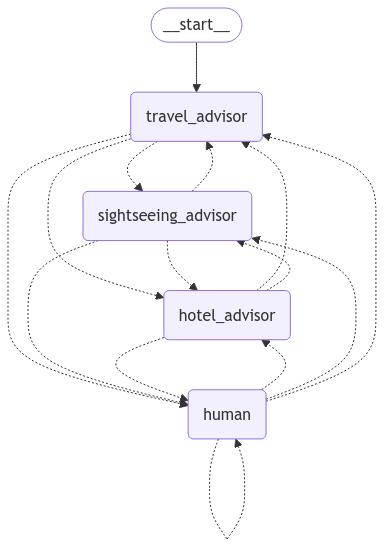

In [111]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

### Test multi-turn conversation

Let's test a multi turn conversation with this application.

In [112]:
import uuid

thread_config = {"configurable": {"thread_id": uuid.uuid4()}}

inputs = [
    # 1st round of conversation,
    {
        "messages": [
            {"role": "user", "content": "i wanna go somewhere warm in the caribbean"}
        ]
    },
    # Since we're using `interrupt`, we'll need to resume using the Command primitive.
    # 2nd round of conversation,
    Command(
        resume="could you recommend a nice hotel in one of the areas and tell me which area it is."
    ),
    # 3rd round of conversation,
    Command(resume="could you recommend something to do near the hotel?"),
]

for idx, user_input in enumerate(inputs):
    print()
    print(f"--- Conversation Turn {idx + 1} ---")
    print()
    print(f"User: {user_input}")
    print()
    for update in graph.stream(
        user_input,
        config=thread_config,
        stream_mode="updates",
    ):
        for node_id, value in update.items():
            if isinstance(value, dict) and value.get("messages", []):
                last_message = value["messages"][-1]
                if last_message["role"] != "ai":
                    continue
                print(f"{last_message['name']}: {last_message['content']}")


--- Conversation Turn 1 ---

User: {'messages': [{'role': 'user', 'content': 'i wanna go somewhere warm in the caribbean'}]}

travel_advisor: The Caribbean is full of warm and beautiful destinations. Some popular options include Jamaica, the Bahamas, the Dominican Republic, and Aruba. Each of these places offers stunning beaches, vibrant culture, and plenty of activities to enjoy. Would you like recommendations on sightseeing or accommodations in any specific location?

--- Conversation Turn 2 ---

User: Command(resume='could you recommend a nice hotel in one of the areas and tell me which area it is.')

travel_advisor: I'll get a hotel recommendation for you.
hotel_advisor: I recommend the "Half Moon Resort" located in Montego Bay, Jamaica. It's a luxurious resort known for its beautiful private beaches, excellent service, and a variety of amenities including golf, spas, and fine dining. Montego Bay is a vibrant area offering plenty of activities, from snorkeling and diving to explor